# ATP Tennis Data - Feature Engineering

In previous notebook, we pre-processed the ATP match data by:
* dropping columns with little data
* cleaning string columns
* imputing any data that we can reasonably impute

For this notebook, we will use the data saved from pre-processing and start doing some basic feature engineering so we can feed  our data to our models to see how we do. My goal is to start training models and see how they do as soon as possible, so we will stick with the following basic feature engineering techniques:
* one hot encode any categorical data - ie, tournament surface, round, winner_ioc, loser_ioc
* extra month from the tournament date
* label each row with 0 as Player 1 losing to Player 2 and 1 as Player 1 beats Player 2
* remove any remaining columns that we

Output of basic feature engineering:
* tournament
    * tournament id - extract from current tourney_id field
    * tournament level - encode
    * month of tournament - extract from tourney_date
    * year of tournament - extract from tourney_date
    * surface - one hot encode
    * draw size
    * best of
* player 1 and player 2
    * player id
    * rank
    * height
    * ioc - encode
    * age
    * seed
    * hand - encode
* match
    * round - encode
* label
    * whether player 1 beat player 2 - 0 - False, 1 - True
    

## Future:
In a future notebook, I plan on implementing more advanced feature engineering with:
* look up matchup history for players
    * match-up stats for pervious matchups
* add match player record leading up to the match for each player (ie, last X matches)
* look up player stats leading up to match for each player (ie, last X matches)
* contruct 2 entries of data per row since match-up and player record leading up to a match will differe depending on which player is player 1 or 2


## Missing Data:

There are some features that are  missing from our dataset. In the future, we could look into somehow scrapping or manually getting these. I looked at the ATP website to see how to get this data, but it is not readily apparent since each player/tournament has some type of unique identifier on their website that I haven't figure out how to get. Here are some potential features to get i the future:


* tournament
    * tournament location - ie, city, country
    * prize money
* player
    * weight
    * backhand - one/two handed
    * number of years as a pro

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json

%matplotlib inline
sns.set()

In [2]:
# Contants

DATASET_DIR = '../datasets'
MODEL_DIR = '../models'
# this is the file we generated from our pre-processing notebook
PREPROCESSED_FILE = f'{DATASET_DIR}/atp_matches_preprocessed.csv'
FEATURE_FILE = f'{DATASET_DIR}/atp_matches_features.csv'

pre = pd.read_csv(PREPROCESSED_FILE, parse_dates=["tourney_date"])
pre = pre.astype({'draw_size': np.int32})


## Let's look at the data to make sure all the types are correct before we being

In [3]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57868 entries, 0 to 57867
Data columns (total 45 columns):
tourney_id       57868 non-null object
tourney_name     57868 non-null object
surface          57868 non-null object
draw_size        57868 non-null int32
tourney_level    57868 non-null object
tourney_date     57868 non-null datetime64[ns]
match_num        57868 non-null int64
winner_id        57868 non-null int64
winner_seed      57868 non-null float64
winner_name      57868 non-null object
winner_hand      57868 non-null object
winner_ht        57868 non-null float64
winner_ioc       57868 non-null object
winner_age       57868 non-null float64
loser_id         57868 non-null int64
loser_seed       57868 non-null float64
loser_name       57868 non-null object
loser_hand       57868 non-null object
loser_ht         57868 non-null float64
loser_ioc        57868 non-null object
loser_age        57868 non-null float64
score            57867 non-null object
best_of          57868 

In [4]:
pre.sample(10).T

,13363,53294,29330,21261,33235,50188,19067,16643,21909,27650
tourney_id,2002-414,2017-0360,2007-438,2005-506,2009-410,2016-0499,2004-416,2003-540,2005-717,2007-410
tourney_name,hamburg masters,marrakech,moscow,buenos aires,monte carlo masters,delray beach,rome masters,wimbledon,houston,monte carlo masters
surface,clay,clay,hard,clay,clay,hard,clay,grass,clay,clay
draw_size,64,32,32,32,64,32,64,128,32,64
tourney_level,m,a,a,a,m,a,m,g,a,m
tourney_date,2002-05-13 00:00:00,2017-04-10 00:00:00,2007-10-08 00:00:00,2005-02-07 00:00:00,2009-04-12 00:00:00,2016-02-15 00:00:00,2004-05-03 00:00:00,2003-06-23 00:00:00,2005-04-18 00:00:00,2007-04-15 00:00:00
match_num,11,298,28,28,22,273,48,23,27,32
winner_id,101965,106432,103582,103292,104527,105449,103176,103852,102839,103344
winner_seed,42,16,19,2,13,6,44,44,25,7
winner_name,wayne ferreira,borna coric,michael berrer,gaston gaudio,stanislas wawrinka,steve johnson,david sanchez,feliciano lopez,nicolas lapentti,ivan ljubicic


# Tournament Info

* tournament id - extract from current tourney_id field
* tournament level - one hot encode
* month of tournament - extract from tourney_date
* year of tournament - extract from tourney_date
* surface - one hot encode
* draw size
* best of


### Extract tournment ID aand Encode

Since players may have an affinity for certainly tournaments because of location or conditions, we should include this into our features

First let's rename the columns since it's rather confusing - currently, tourney_id is a composite of {year}-{id}. ID is alphanumeric so we need to encode these

In [5]:
matches = pre
matches = matches.rename({"tourney_id": "tourney_year_plus_id"}, axis=1)
matches["tourney_id"] = matches.tourney_year_plus_id.apply(lambda x: x.split("-")[1])
matches.sample(5, random_state=1).tourney_id

19830     419
49384    7290
32731     407
34227     418
53983     540
Name: tourney_id, dtype: object

In [6]:


tidle = LabelEncoder()
tid_labels = tidle.fit_transform(matches['tourney_id'])
tid_map = {label: num for num, label in enumerate(tidle.classes_)}
print(tid_map)

matches["tourney_id_label"] = matches["tourney_id"].map(tid_map)

# save off map to be used later
with open(f'{MODEL_DIR}/tid_map.json', 'w') as file:
    json.dump(tid_map, file)
    
matches.sample(10)[["tourney_id", "tourney_id_label"]]

{'0301': 0, '0308': 1, '0311': 2, '0314': 3, '0315': 4, '0316': 5, '0319': 6, '0321': 7, '0322': 8, '0328': 9, '0329': 10, '0337': 11, '0341': 12, '0352': 13, '0360': 14, '0375': 15, '0402': 16, '0407': 17, '0410': 18, '0414': 19, '0421': 20, '0424': 21, '0425': 22, '0429': 23, '0439': 24, '0451': 25, '0495': 26, '0496': 27, '0499': 28, '0500': 29, '0506': 30, '0533': 31, '0568': 32, '0605': 33, '0717': 34, '0741': 35, '0773': 36, '0891': 37, '1536': 38, '1720': 39, '2276': 40, '301': 41, '306': 42, '308': 43, '311': 44, '312': 45, '314': 46, '315': 47, '316': 48, '317': 49, '319': 50, '321': 51, '322': 52, '325': 53, '326': 54, '327': 55, '328': 56, '329': 57, '3348': 58, '336': 59, '337': 60, '338': 61, '339': 62, '341': 63, '3465': 64, '348': 65, '352': 66, '357': 67, '359': 68, '360': 69, '375': 70, '379': 71, '401': 72, '402': 73, '403': 74, '404': 75, '407': 76, '408': 77, '409': 78, '410': 79, '414': 80, '416': 81, '418': 82, '419': 83, '420': 84, '421': 85, '422': 86, '423': 87

,tourney_id,tourney_id_label
6360,301,41
9414,580,117
2671,773,144
57568,0429,23
49311,425,89
51147,0321,7
23812,339,62
30803,306,42
26885,580,117
49722,520,111


### Tournament Level

Tournament level does have some type of implicit ordinality to them since tournaments are worth different points according to their levels with 'g' (grand slams) worth the most number of points

We will do a custom encoding for these

Here are the point values for winner the levels:
* g - grand slam - 2000
* f - tour final - 1500
* m - masters - 1000
* a - other tour event - anywhere between 250 to 500 depending on the series

In [7]:
np.unique(matches.tourney_level)

array(['a', 'f', 'g', 'm'], dtype=object)

In [8]:
import json

level_map = {'g': 1, 'f': 2, 'm': 3, 'a': 4}
matches["tourney_level_label"] = matches['tourney_level'].map(level_map)
# let's check our work
matches.sample(10)[["tourney_level", "tourney_level_label"]]

# let's save off the map for later use
with open(f'{MODEL_DIR}/tourney_level_map.json', 'w') as file:
    json.dump(level_map, file)

### Tournamant year and Month

We can extract this from the tourney_date

In [9]:
matches["tourney_year"] = matches.tourney_date.dt.year
matches["tourney_month"] = matches.tourney_date.dt.month
matches.sample(10)[["tourney_year", "tourney_month", "tourney_date"]]

,tourney_year,tourney_month,tourney_date
36280,2010,5,2010-05-16
25093,2006,5,2006-05-29
34250,2009,8,2009-08-02
43975,2013,4,2013-04-08
15528,2003,2,2003-02-17
54449,2017,8,2017-08-14
50276,2016,2,2016-02-22
3047,1998,10,1998-10-26
19269,2004,5,2004-05-24
49932,2016,1,2016-01-18


### Tournament Surface

There is no ordinality here so we can just use a label encoder

In [10]:

gle = LabelEncoder()
surface_labels = gle.fit_transform(matches['surface'])
surface_map = {label: num for num, label in enumerate(gle.classes_)}
print(surface_map)

matches["surface_label"] = matches["surface"].map(surface_map)

# save off map to be used later
with open(f'{MODEL_DIR}/surface_map.json', 'w') as file:
    json.dump(surface_map, file)
    
matches.sample(10)[["surface", "surface_label"]]

{'carpet': 0, 'clay': 1, 'grass': 2, 'hard': 3}


,surface,surface_label
46544,hard,3
32619,hard,3
52907,hard,3
56967,hard,3
35488,hard,3
8771,hard,3
20519,hard,3
9676,clay,1
8572,hard,3
51252,grass,2


# Generate Player Features

Most are already numbers that we can feed into the model - we will just keep these for now

### Player origin (ioc)

Again there is no ordinality to this so we will use the LabelEncoder

In [11]:
iocle = LabelEncoder()
# we have to append loser and winner list to get comprehensive list
ioc_labels = iocle.fit_transform(matches["loser_ioc"].append(matches["winner_ioc"]))
ioc_map = {label: num for num, label in enumerate(iocle.classes_)}
print(ioc_map)

matches["loser_ioc_label"] = matches["loser_ioc"].map(ioc_map)
matches["winner_ioc_label"] = matches["winner_ioc"].map(ioc_map)

# save off map to be used later
with open(f'{MODEL_DIR}/ioc_map.json', 'w') as file:
    json.dump(ioc_map, file)
    
matches.sample(10)[["loser_ioc", "loser_ioc_label", "winner_ioc", "winner_ioc_label"]]

{'alg': 0, 'arg': 1, 'arm': 2, 'aus': 3, 'aut': 4, 'aze': 5, 'bah': 6, 'bar': 7, 'bel': 8, 'bih': 9, 'blr': 10, 'bra': 11, 'bul': 12, 'can': 13, 'chi': 14, 'chn': 15, 'col': 16, 'crc': 17, 'cro': 18, 'cyp': 19, 'cze': 20, 'den': 21, 'dom': 22, 'ecu': 23, 'egy': 24, 'esa': 25, 'esp': 26, 'est': 27, 'fin': 28, 'fra': 29, 'gbr': 30, 'geo': 31, 'ger': 32, 'gre': 33, 'hkg': 34, 'hun': 35, 'ind': 36, 'irl': 37, 'isr': 38, 'ita': 39, 'jpn': 40, 'kaz': 41, 'kor': 42, 'kuw': 43, 'lat': 44, 'ltu': 45, 'lux': 46, 'mar': 47, 'mas': 48, 'mda': 49, 'mex': 50, 'mkd': 51, 'mon': 52, 'ned': 53, 'nor': 54, 'nzl': 55, 'pak': 56, 'par': 57, 'per': 58, 'phi': 59, 'pol': 60, 'por': 61, 'qat': 62, 'rou': 63, 'rsa': 64, 'rus': 65, 'slo': 66, 'srb': 67, 'sui': 68, 'svk': 69, 'swe': 70, 'tha': 71, 'tog': 72, 'tpe': 73, 'tun': 74, 'tur': 75, 'uae': 76, 'ukr': 77, 'uru': 78, 'usa': 79, 'uzb': 80, 'ven': 81, 'vie': 82, 'zim': 83}


,loser_ioc,loser_ioc_label,winner_ioc,winner_ioc_label
14077,arg,1,bra,11
13843,rsa,64,gbr,30
29346,ita,39,arg,1
46579,ned,53,sui,68
9523,par,57,bra,11
19281,cze,20,tha,71
57091,fra,29,srb,67
35723,ger,32,kaz,41
23085,usa,79,sui,68
347,zim,83,aus,3


### Player Hand - (l/r/u)

This is simple categorial data - will use LabelEncoder

In [12]:
handcle = LabelEncoder()
# we have to append loser and winner list to get comprehensive list
hand_labels = handcle.fit_transform(matches["loser_hand"].append(matches["winner_hand"]))
hand_map = {label: num for num, label in enumerate(handcle.classes_)}
print(hand_map)

matches["loser_hand_label"] = matches["loser_hand"].map(hand_map)
matches["winner_hand_label"] = matches["winner_hand"].map(hand_map)

# save off map to be used later
with open(f'{MODEL_DIR}/hand_map.json', 'w') as file:
    json.dump(hand_map, file)
    
matches.sample(10)[["loser_hand", "loser_hand_label", "winner_hand", "winner_hand_label"]]

{'l': 0, 'r': 1, 'u': 2}


,loser_hand,loser_hand_label,winner_hand,winner_hand_label
3711,r,1,r,1
27363,r,1,r,1
47249,r,1,r,1
26467,r,1,l,0
56806,r,1,r,1
48749,r,1,r,1
38553,r,1,r,1
45282,r,1,r,1
7027,r,1,r,1
11954,r,1,r,1


## Match Features

Only feature we will use for now is round. There is an ordinality to the rounds so we will use a custome encoding

Couple issues with this:

'rr' - means round robin. This usually means that all players in a tournament is divided into multiple flights (ie, 2). All players in the flight play against each other. The year end final for instance has 8 players. Top 2 players from each flight make it to semi finals. Winner of that match goes to finals. So rr could mean any of the 3 matches a player would play in the flight. We will just pick the next unique number to encode this.

https://en.wikipedia.org/wiki/ATP_Finals

'br' - Not sure what this indicates. Will encode this as the last value

In [13]:
np.unique(matches["round"])

array(['br', 'f', 'qf', 'r128', 'r16', 'r32', 'r64', 'rr', 'sf'],
      dtype=object)

In [14]:
round_map = {'f': 1, 
            'sf': 2,
            'qf': 3,
            'r16': 4,
            'r32': 5,
            'r64': 6,
            'r128': 7,
            'rr': 8,
            'br': 9}
matches["round_label"] = matches["round"].map(round_map)

# save off map to be used later
with open(f'{MODEL_DIR}/round_map.json', 'w') as file:
    json.dump(round_map, file)
    
matches.sample(10)[["round", "round_label"]]


,round,round_label
44415,r128,7
41408,r64,6
43987,r16,4
26389,r32,5
4246,r32,5
21821,qf,3
19009,r16,4
28160,r64,6
14351,r64,6
22348,r32,5


# Let's check out our data one more time

In [15]:
matches.sample(10).T

,21463,10835,50171,43553,41174,45308,50721,38678,35712,31314
tourney_year_plus_id,2005-495,2001-440,2016-0407,2013-424,2012-404,2013-560,2016-0773,2011-410,2010-404,2008-315
tourney_name,dubai,s hertogenbosch,rotterdam,san jose,indian wells masters,us open,bucharest,monte carlo masters,indian wells masters,newport
surface,hard,grass,hard,hard,hard,hard,clay,clay,hard,grass
draw_size,32,32,32,32,128,128,32,64,128,32
tourney_level,a,a,a,a,m,g,a,m,m,a
tourney_date,2005-02-21 00:00:00,2001-06-18 00:00:00,2016-02-08 00:00:00,2013-02-11 00:00:00,2012-03-08 00:00:00,2013-08-26 00:00:00,2016-04-18 00:00:00,2011-04-10 00:00:00,2010-03-11 00:00:00,2008-07-07 00:00:00
match_num,13,30,287,9,84,72,286,33,5,19
winner_id,103990,103084,104259,105028,104545,103720,106298,103990,103752,103868
winner_seed,5,14,9,16,11,62,13,21,51,9
winner_name,tommy robredo,guillermo canas,philipp kohlschreiber,jesse levine,john isner,lleyton hewitt,lucas pouille,tommy robredo,simon greul,ivan navarro


# Generate Features and Ground Truth

This is going to be a little bit tricky. If we leave the columns as it, all of our labels for winner/loser would be 1 since winner column is first.

Instead, we are going to have to loop through all rows and randomly place winner or loser as player 1 so that we can have labels that are both 0 and 1

In [16]:
import random

tourney_cols = ["tourney_id_label", "tourney_level_label", "tourney_year", "tourney_month", "surface_label", "draw_size", "round_label"]

def generate_feature_row(row: pd.Series, p1winner: bool) -> dict:
    m = {}
    # first add static columns for tournament and match
    for tc in tourney_cols:
        m[tc] = row[tc]
        
    # now depending on what random gives us either put winner as p1 or loser as p1
    m1 = {}
    if p1winner:
        m1 = {
            "p1": row.winner_id,
            "p1_rank": row.winner_rank,
            "p1_ht": row.winner_ht,
            "p1_ioc": row.winner_ioc_label,
            "p1_age": row.winner_age,
            "p1_seed": row.winner_seed,
            "p1_hand": row.winner_hand_label,
            "p2": row.loser_id,
            "p2_rank": row.loser_rank,
            "p2_ht": row.loser_ht,
            "p2_ioc": row.loser_ioc_label,
            "p2_age": row.loser_age,
            "p2_seed": row.loser_seed,
            "p2_hand": row.loser_hand_label,
            "p1_winner": 1
        }
    else:
        m1 = {
            "p1": row.loser_id,
            "p1_rank": row.loser_rank,
            "p1_ht": row.loser_ht,
            "p1_ioc": row.loser_ioc_label,
            "p1_age": row.loser_age,
            "p1_seed": row.loser_seed,
            "p1_hand": row.loser_hand_label,
            "p2": row.winner_id,
            "p2_rank": row.winner_rank,
            "p2_ht": row.winner_ht,
            "p2_ioc": row.winner_ioc_label,
            "p2_age": row.winner_age,
            "p2_seed": row.winner_seed,
            "p2_hand": row.winner_hand_label,
            "p1_winner": 0
        }
    m.update(m1)
    return m

features = pd.DataFrame()
for _, row in matches.iterrows():
    d = generate_feature_row(row, round(random.uniform(0,1)) == 0)
    features = features.append(d, ignore_index=True)
    


In [17]:
type_map = {
    "tourney_id_label": np.int32,
    "tourney_level_label": np.int32,
    "tourney_year": np.int32,
    "tourney_month": np.int32,
    "surface_label": np.int32,
    "draw_size": np.int32,
    "round_label": np.int32,
    "p1": np.int32,
    "p1_rank": np.int32,
    "p1_ioc": np.int32,
    "p1_seed": np.int32,
    "p1_hand": np.int32,
    "p2": np.int32,
    "p2_rank": np.int32,
    "p2_ioc": np.int32,
    "p2_seed": np.int32,
    "p2_hand": np.int32,
    "p1_winner": np.int32    
}

features = features.astype(type_map)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57868 entries, 0 to 57867
Data columns (total 22 columns):
draw_size              57868 non-null int32
p1                     57868 non-null int32
p1_age                 57868 non-null float64
p1_hand                57868 non-null int32
p1_ht                  57868 non-null float64
p1_ioc                 57868 non-null int32
p1_rank                57868 non-null int32
p1_seed                57868 non-null int32
p1_winner              57868 non-null int32
p2                     57868 non-null int32
p2_age                 57868 non-null float64
p2_hand                57868 non-null int32
p2_ht                  57868 non-null float64
p2_ioc                 57868 non-null int32
p2_rank                57868 non-null int32
p2_seed                57868 non-null int32
round_label            57868 non-null int32
surface_label          57868 non-null int32
tourney_id_label       57868 non-null int32
tourney_level_label    57868 non-null int32
tou

In [18]:
features.sample(10).T

,49172,33711,26330,6326,53754,50467,2376,14576,3300,23935
draw_size,128.00,32.00,32.00,32.00,128.00,128.00,64.00,32.00,32.00,32.00
p1,105668.00,104620.00,103808.00,103018.00,105777.00,105173.00,102446.00,103118.00,102644.00,102860.00
p1_age,24.36,23.67,25.20,22.49,26.04,27.73,23.96,24.64,23.37,29.32
p1_hand,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00
p1_ht,203.00,183.00,188.00,196.00,188.00,183.00,193.00,188.00,183.00,183.00
p1_ioc,60.00,39.00,39.00,10.00,12.00,29.00,77.00,63.00,1.00,1.00
p1_rank,49.00,66.00,103.00,74.00,13.00,64.00,72.00,562.00,60.00,51.00
p1_seed,42.00,23.00,21.00,18.00,11.00,53.00,27.00,32.00,19.00,21.00
p1_winner,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00
p2,105676.00,104925.00,103656.00,102548.00,103990.00,105011.00,102903.00,102287.00,102223.00,103786.00


# Save to File

In [19]:
features.to_csv(FEATURE_FILE, index=False)

# Check that we are roughly evenly distributed since we used the uniform distribution

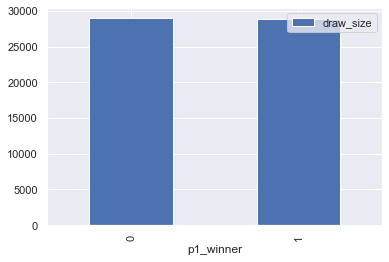

In [20]:
features[['p1_winner','draw_size']].groupby("p1_winner").count().plot(kind='bar')